In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

%matplotlib inline

In [2]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

train = pd.read_csv('adult_data.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')


adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

---
# 1. Preliminary Data Analysis

In [3]:
adult

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 1.1. Columns and their types

In [4]:
# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
print(adult.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


## 1.2. Data

In [5]:
# Top 5 records
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## 1.3. Summary Statistics

In [6]:
adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## 1.4. Missing values

In [7]:
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' records')



workclass: 2799 records
occupation: 2809 records
native-country: 857 records


In [8]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

### 1.4.1. Filling in missing values for Attribute workclass

In [9]:
test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

/Users/abhaya.panda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Private             35800
Self-emp-not-inc     3876
Local-gov            3139
State-gov            1982
Self-emp-inc         1696
Federal-gov          1432
Never-worked          896
Without-pay            21
?                       0
Name: workclass, dtype: int64
[Private, Local-gov, Never-worked, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Without-pay]
Categories (8, object): [Private, Local-gov, Never-worked, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Without-pay]


### 1.4.2. Filling in missing values for Occupation

In [10]:

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

/Users/abhaya.panda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prof-specialty       7762
Craft-repair         6545
Exec-managerial      6141
Adm-clerical         5877
Sales                5578
Other-service        5145
Machine-op-inspct    3059
Transport-moving     2395
Handlers-cleaners    2099
Farming-fishing      1525
Tech-support         1458
Protective-serv       991
Priv-house-serv       252
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
[Machine-op-inspct, Farming-fishing, Protective-serv, Adm-clerical, Other-service, ..., Sales, Priv-house-serv, Transport-moving, Handlers-cleaners, Armed-Forces]
Length: 14
Categories (14, object): [Machine-op-inspct, Farming-fishing, Protective-serv, Adm-clerical, ..., Priv-house-serv, Transport-moving, Handlers-cleaners, Armed-Forces]


### 1.4.3. Filling in missing values for Native Country

In [11]:

test_data = adult[(adult['native-country'].values == '?')].copy()
test_label = test_data['native-country']

train_data = adult[(adult['native-country'].values != '?')].copy()
train_label = train_data['native-country']

test_data.drop(columns = ['native-country'], inplace = True)
train_data.drop(columns = ['native-country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult['native-country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native-country'].values == '?'),'native-country'] = overall_pred.values
print(adult['native-country'].value_counts())
print(adult['native-country'].unique())

/Users/abhaya.panda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


United-States                 44641
Mexico                          962
Philippines                     305
Germany                         206
Puerto-Rico                     186
Canada                          182
India                           155
El-Salvador                     155
Cuba                            138
England                         127
China                           126
South                           122
Jamaica                         107
Italy                           105
Dominican-Republic              104
Japan                            94
Guatemala                        89
Poland                           87
Vietnam                          87
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           66
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [12]:
# Resetting the categories

adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native-country'] = adult['native-country'].cat.remove_categories('?')



## 1.5. Correlation Matrix

In [13]:
display(adult.corr())

print('We see that none of the columns are highly correlated.')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.


---
# 2. Exploratory Analysis

In [14]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in adult[['educational-num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1. Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.


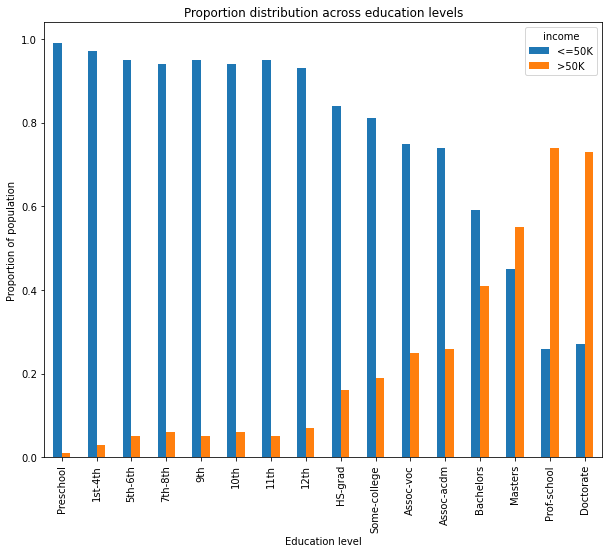

In [15]:

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

print('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')
        

## 2.2. Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         


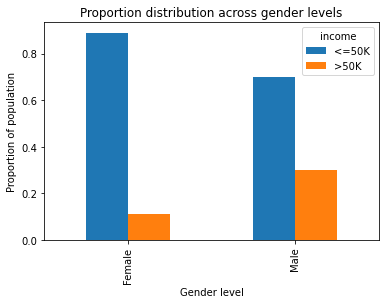

In [16]:

gender = round(pd.crosstab(adult.gender, adult.income).div(pd.crosstab(adult.gender, adult.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)
ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

print('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.


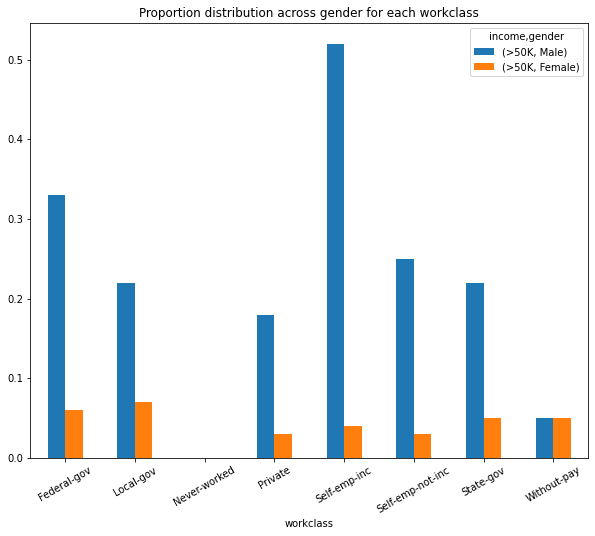

In [17]:
gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.gender]).div(pd.crosstab(adult.workclass, [adult.income, adult.gender]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

print('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

## 2.3. Occupation vs Income

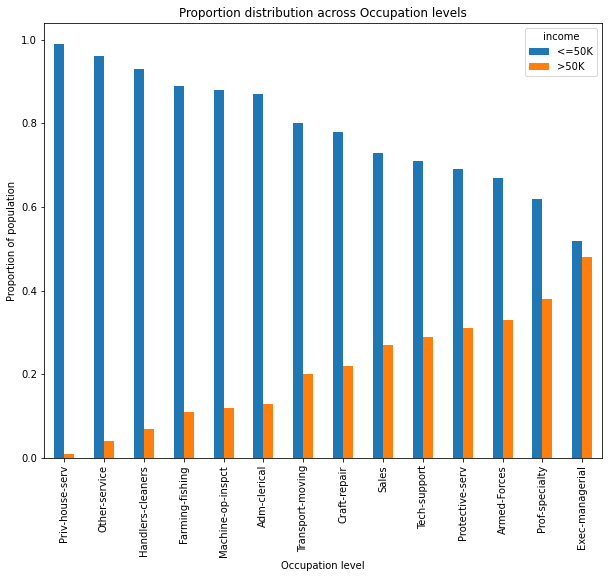

In [18]:

occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

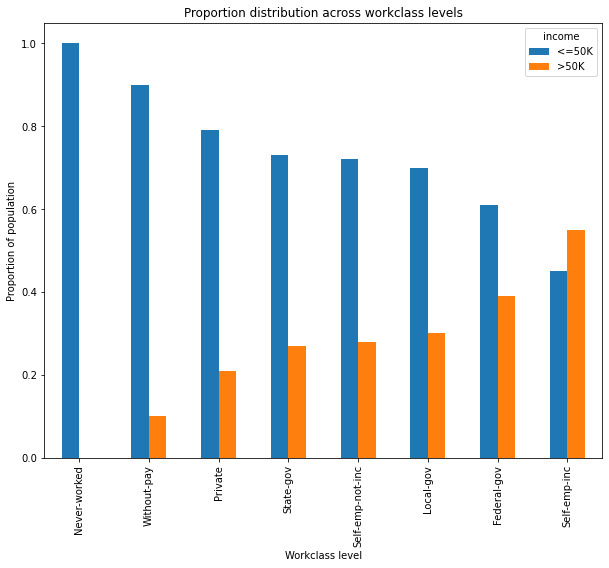

In [19]:
workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

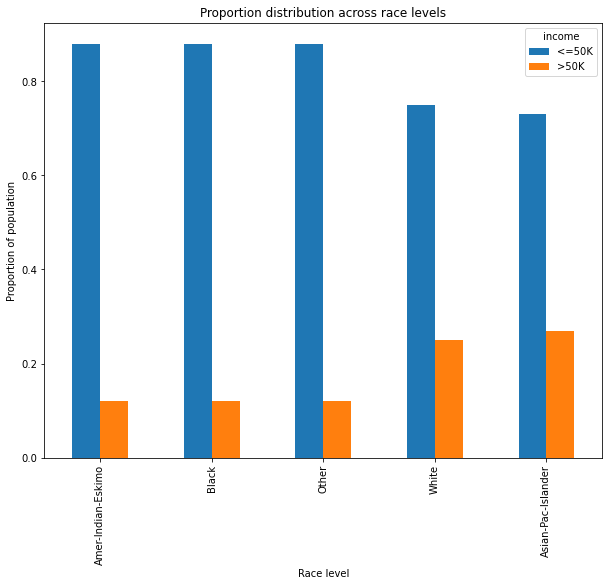

In [20]:
race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

## 2.6. Native Country

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.


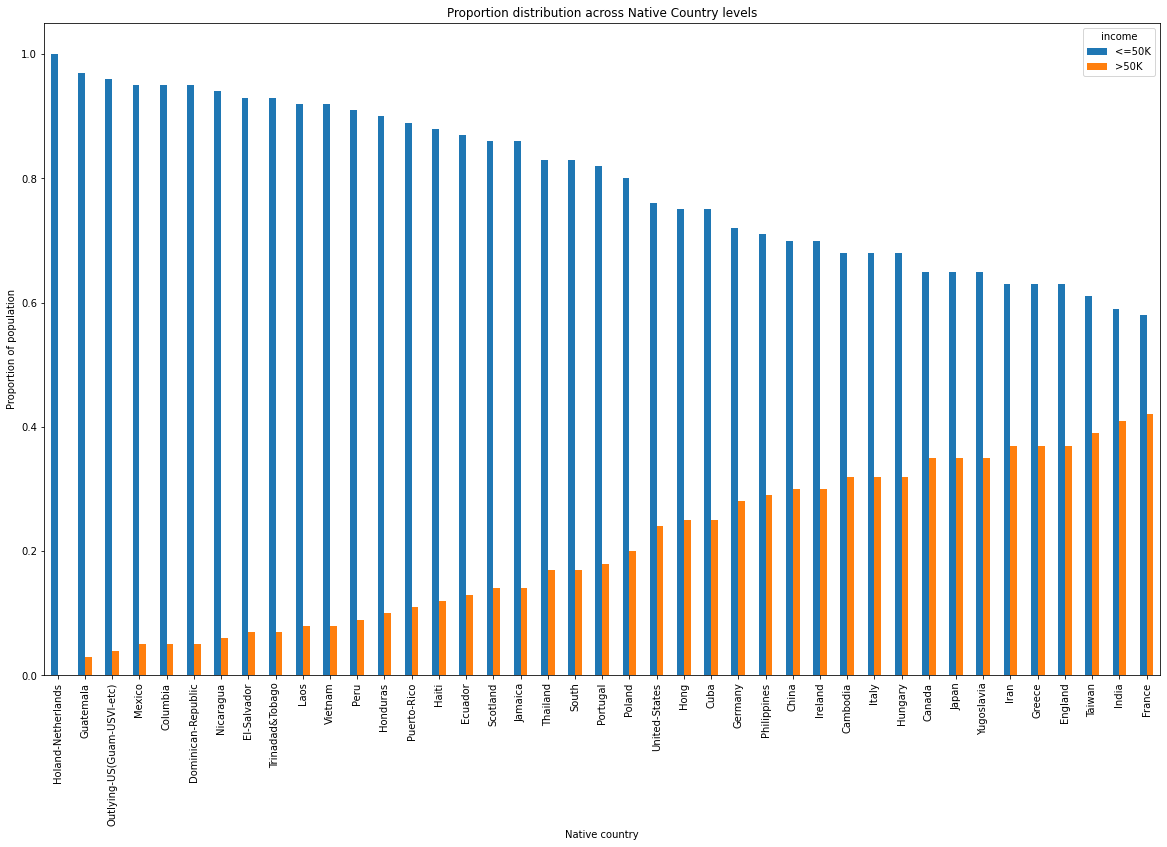

In [21]:
native_country = round(pd.crosstab(adult['native-country'], adult.income).div(pd.crosstab(adult['native-country'], adult.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)
ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

print('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')


## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 


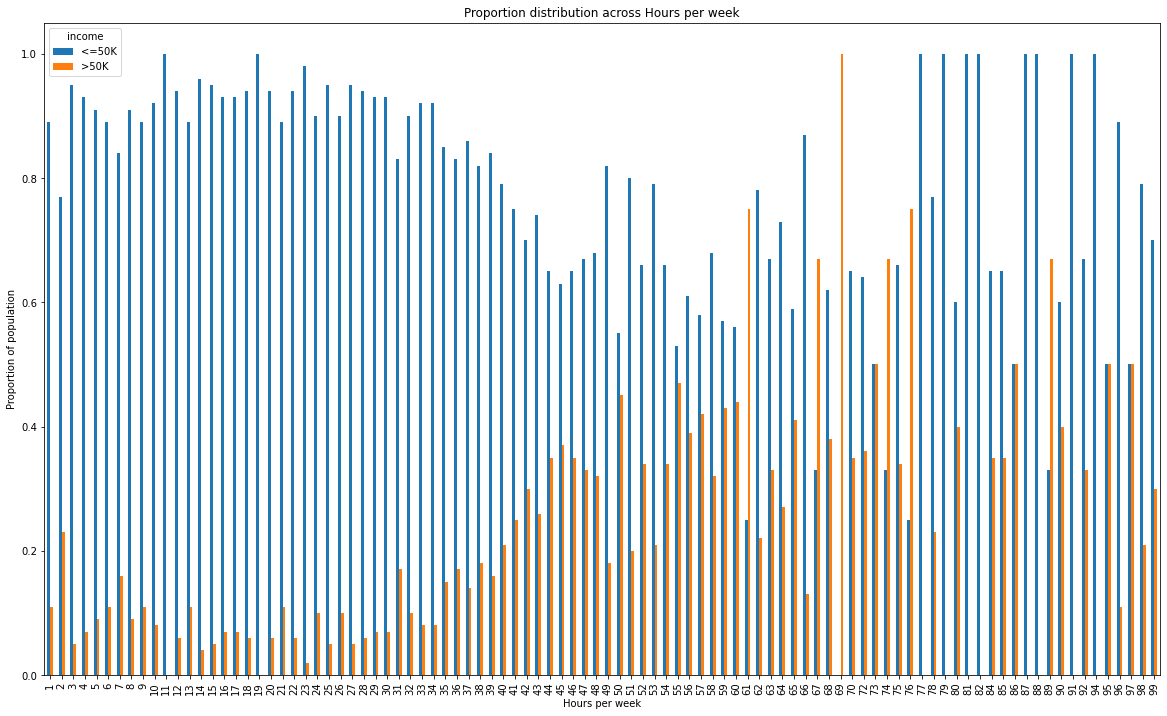

In [22]:
hours_per_week = round(pd.crosstab(adult['hours-per-week'], adult.income).div(pd.crosstab(adult['hours-per-week'], adult.income).apply(sum,1),0),2)
# hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

print('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')


### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.


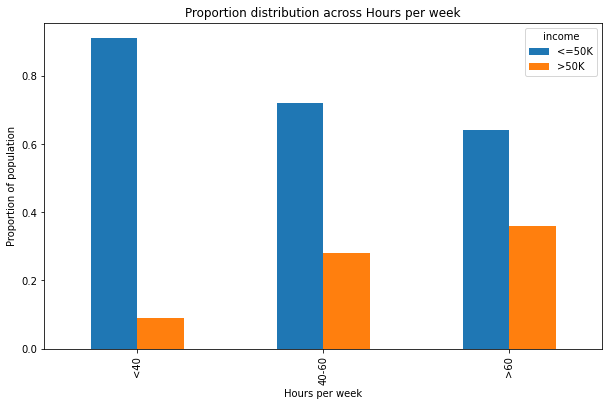

In [23]:

adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours-per-week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum,1),0),2)

hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

print('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')


---
# 3. Data Transformations

## 3.1. Feature Selection

In [47]:
# Remove education and fnlwgt
#adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

print('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
print('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
print('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')

* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.
* I use the categorical Hours work column and drop the 'hour-per-week' column
* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.


## 3.2 Normalization

## Box plot

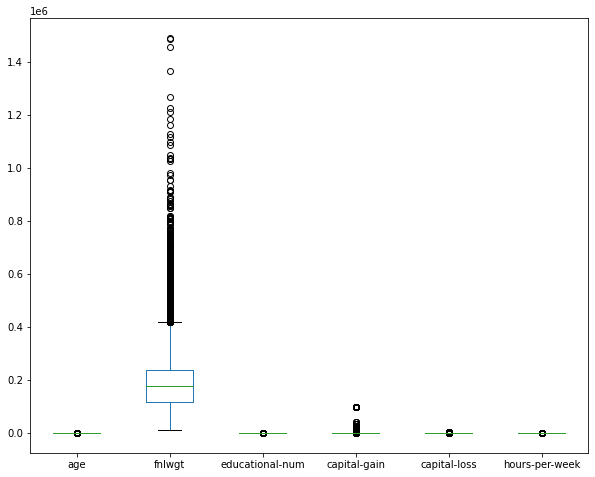

In [25]:
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [26]:
print ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 


---
# 4. Model Development & Classification 

## 4.1. Data Preparation'

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithms tend to work better on this format of data.

I use one-hot encoding to represent all the categorical features in the dataset. 


In [27]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')


In [28]:
# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, adult_label, test_size  = 0.25)

In [29]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data) 

In [30]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out


## 4.2. Model Development
### 4.2.1. Decision Tree

For the decision tree classifier, I experimented with the splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [31]:
# Gini 
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 0.05, min_samples_leaf = 0.001, max_features = None)
clf_gini = clf_gini.fit(train_data, train_label)
clf_gini_pred = clf_gini.predict(test_data)
DTree_Gini = model_eval(test_label, clf_gini_pred)
print('Desicion Tree using Gini Index : %.2f percent.' % (round(DTree_Gini['accuracy']*100,2)))


# Entropy
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 0.05, min_samples_leaf = 0.001)
clf_entropy = clf_entropy.fit(train_data, train_label)
clf_entropy_pred = clf_entropy.predict(test_data)
DTree_Entropy = model_eval(test_label, clf_entropy_pred)
print('Desicion Tree using Entropy : %.2f percent.' % (round(DTree_Entropy['accuracy']*100,2)))


ovl_dtree = round(pd.DataFrame([DTree_Entropy, DTree_Gini], index = ['DTree_Entropy','DTree_Gini']),4)
display(ovl_dtree)

Desicion Tree using Gini Index : 85.99 percent.
Desicion Tree using Entropy : 85.70 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
DTree_Entropy,0.8570,0.7896,0.5531,0.6505,0.5531,0.9533,0.1430
DTree_Gini,0.8599,0.7757,0.5875,0.6686,0.5875,0.9462,0.1401


### 4.2.2. Support Vector Machine
For the SVM classifier, I experimented with the various available kernels, the penalty of the error term and the tolerance for stopping criteria. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Kernel:** rbf (Marginally outperformed 'linear, 'poly' and 'sigmoid' kernels.)
*	**C, penalty of the error term:** 1 (Best amongst 0.1, 0.5, 1 and 10)
*	**Tolerance for stopping criteria:** 1e-3 (Best amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)


In [32]:
# rbf kernal
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)
svm_clf_rbf.fit(train_data, train_label)
svm_clf_rbf_pred = svm_clf_rbf.predict(test_data)
SVM_rbf = model_eval(test_label, svm_clf_rbf_pred)
print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))

# Linear kernel
svm_clf_linear = svm.SVC(kernel = 'linear')
svm_clf_linear.fit(train_data, train_label)
svm_clf_linear_pred = svm_clf_linear.predict(test_data)
SVM_linear = model_eval(test_label, svm_clf_linear_pred)
print('SVM using linear kernel : %.2f percent.' % (round(SVM_linear['accuracy']*100,2)))


# Poly kernal
svm_clf_poly = svm.SVC(kernel = 'poly')
svm_clf_poly.fit(train_data, train_label)
svm_clf_poly_pred = svm_clf_poly.predict(test_data)
SVM_poly = model_eval(test_label, svm_clf_poly_pred)
print('SVM using poly kernel : %.2f percent.' % (round(SVM_poly['accuracy']*100,2)))


svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')
svm_clf_sigmoid.fit(train_data, train_label)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(test_data)
SVM_sigmoid = model_eval(test_label, svm_clf_sigmoid_pred)
print('SVM using sigmoid kernel : %.2f percent.' % (round(SVM_sigmoid['accuracy']*100,2)))


# Model Evaluation
ovl_svm = round(pd.DataFrame([SVM_rbf, SVM_linear, SVM_poly, SVM_sigmoid], index = ['SVM_rbf','SVM_linear', 'SVM_poly', 'SVM_sigmoid']),4)
display(ovl_svm)

SVM using rbf kernel : 85.34 percent.
SVM using linear kernel : 85.38 percent.
SVM using poly kernel : 83.51 percent.
SVM using sigmoid kernel : 82.53 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
SVM_rbf,0.8534,0.7576,0.5745,0.6535,0.5745,0.9418,0.1466
SVM_linear,0.8538,0.7521,0.5854,0.6584,0.5854,0.9389,0.1462
SVM_poly,0.8351,0.7271,0.5034,0.5949,0.5034,0.9401,0.1649
SVM_sigmoid,0.8253,0.6530,0.5848,0.6170,0.5848,0.9015,0.1747


### 4.2.3. Ensemble Models

### 4.2.3.1. Random Forest
For the random forests classifier, I experimented with the number of trees, splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Num estimators:** 100 (Best amongst 10, 50 and 100)
*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [33]:
# Gini
r_forest_gini = RandomForestClassifier(n_estimators=100, criterion = 'gini', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_gini.fit(train_data, train_label)
r_forest_gini_pred = r_forest_gini.predict(test_data)
rforest_gini = model_eval(test_label, r_forest_gini_pred)
print('Random Forest using Gini Index : %.2f percent.' % (round(rforest_gini['accuracy']*100,2)))

# Entropy
r_forest_entropy = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_entropy.fit(train_data, train_label)
r_forest_entropy_pred = r_forest_entropy.predict(test_data)
rforest_entropy = model_eval(test_label, r_forest_entropy_pred)
print('Random Forest using Entropy : %.2f percent.' % (round(rforest_entropy['accuracy']*100,2)))

# Model Evaulation
ovl_rf = round(pd.DataFrame([rforest_gini, rforest_entropy], index = ['rforest_gini','rforest_entropy']),4)
display(ovl_rf)

Random Forest using Gini Index : 86.06 percent.
Random Forest using Entropy : 85.99 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
rforest_gini,0.8606,0.7766,0.5905,0.6709,0.5905,0.9462,0.1394
rforest_entropy,0.8599,0.7852,0.5749,0.6638,0.5749,0.9502,0.1401


### 4.2.3.2. Adaboost
For the adaboost classifier, I experimented with base estimator from which the boosted ensemble is built and number of estimators. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Base Estimator:** DecisionTreeClassifier
*	**Num estimators:** 100 (Best amongst 10, 50 and 100.)


In [34]:
ada = AdaBoostClassifier(n_estimators=100)                     
ada.fit(train_data, train_label)
ada_pred = ada.predict(test_data)
adaboost = model_eval(test_label, ada_pred)
print('Adaboost : %.2f percent.' % (round(adaboost['accuracy']*100,2)))

# Model Evaulation
ovl_ada = round(pd.DataFrame([adaboost], index = ['adaboost']),4)
display(ovl_ada)

Adaboost : 86.73 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8673,0.7806,0.6236,0.6933,0.6236,0.9445,0.1327


### 4.2.4. Logistic Regression

In [35]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = model_eval(test_label, log_reg_pred)
print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

# Model Evaulation
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),4)
display(ovl_logreg)

Logistic Regression : 85.50 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.855,0.7409,0.6113,0.6699,0.6113,0.9323,0.145


### 4.2.5. k Nearest Neighbours
For the K nearest neighbours classifier, I experimented with the num of neighbours values, every odd number ranging from 1 to 50.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn_outs = []
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data, train_label) 
    knn_pred = knn.predict(test_data)
    knn_perf = model_eval(test_label, knn_pred)
    knn_perf['k'] = i
    knn_outs.append(knn_perf)

# Model Evaulation
ovl_knn = round(pd.DataFrame(knn_outs),4)
display(ovl_knn)

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate,k
0,0.7865,0.5567,0.5531,0.5549,0.5531,0.8605,0.2135,1
1,0.8134,0.6235,0.5660,0.5934,0.5660,0.8917,0.1866,3
2,0.8260,0.6592,0.5728,0.6130,0.5728,0.9062,0.1740,5
3,0.8288,0.6704,0.5671,0.6144,0.5671,0.9117,0.1712,7
4,0.8305,0.6756,0.5684,0.6174,0.5684,0.9135,0.1695,9
5,0.8326,0.6817,0.5708,0.6213,0.5708,0.9156,0.1674,11
6,0.8330,0.6803,0.5773,0.6246,0.5773,0.9141,0.1670,13
7,0.8329,0.6828,0.5708,0.6218,0.5708,0.9160,0.1671,15
8,0.8336,0.6840,0.5732,0.6237,0.5732,0.9161,0.1664,17
9,0.8320,0.6819,0.5654,0.6182,0.5654,0.9164,0.1680,19


---
# 5. Model Evaluation
## 5.1. Overall Performance Statistics

In [37]:
overall_eval = pd.concat([ovl_dtree, ovl_svm, ovl_rf, ovl_ada, ovl_logreg], axis = 0)
overall_eval.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

print('Combing the performance statistics of all the model developed, as seen in table below, \
        we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812) \
        and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of \
        accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM \
        models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and \
        specificity of all the models developed.')

display(overall_eval)

Combing the performance statistics of all the model developed, as seen in table below,         we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812)         and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of         accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM         models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and         specificity of all the models developed.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8673,0.7806,0.6236,0.6933,0.6236,0.9445,0.1327
rforest_gini,0.8606,0.7766,0.5905,0.6709,0.5905,0.9462,0.1394
logistic_reg,0.8550,0.7409,0.6113,0.6699,0.6113,0.9323,0.1450
DTree_Gini,0.8599,0.7757,0.5875,0.6686,0.5875,0.9462,0.1401
rforest_entropy,0.8599,0.7852,0.5749,0.6638,0.5749,0.9502,0.1401
SVM_linear,0.8538,0.7521,0.5854,0.6584,0.5854,0.9389,0.1462
SVM_rbf,0.8534,0.7576,0.5745,0.6535,0.5745,0.9418,0.1466
DTree_Entropy,0.8570,0.7896,0.5531,0.6505,0.5531,0.9533,0.1430
SVM_sigmoid,0.8253,0.6530,0.5848,0.6170,0.5848,0.9015,0.1747
SVM_poly,0.8351,0.7271,0.5034,0.5949,0.5034,0.9401,0.1649


## 5.2. ROC Curve

In [45]:
def generateRoc(test_data, test_label, classifiers, pred_labels, plot_labels, limiter):
    
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    
    y_test = label_binarize(test_label, classes=['<=50K', '>50K'])
    plt.figure()
    
    for i in range(len(classifiers)):
        
        if plot_labels[i] not in limiter:
            continue
        
        y_score = classifiers[i].predict_proba(test_data)
        pos_class_index = list(np.unique(pred_labels[i])).index('>50K')
        
        fpr, tpr, thres = metrics.roc_curve(y_test.ravel(),y_score[:,pos_class_index], pos_label=1)
                               
        lw = 2
        plt.plot(fpr, tpr, color=color[i % len(color)],lw=lw, label=plot_labels[i])
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


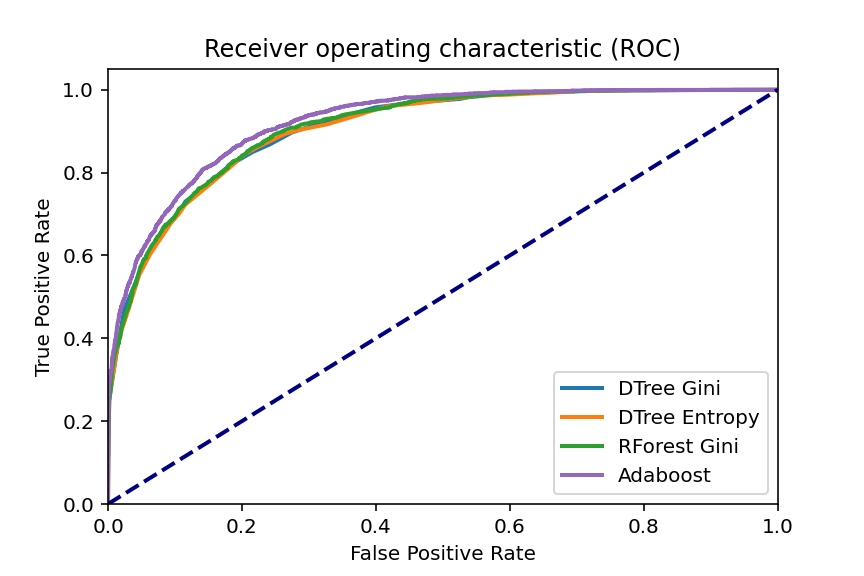

In [46]:
%matplotlib notebook
classifier_list = [clf_gini
                ,clf_entropy
                ,r_forest_gini
                ,r_forest_entropy
                ,ada
                ,log_reg
                ] 
pred_list = [clf_gini_pred
            ,clf_entropy_pred
            ,r_forest_gini_pred
            ,r_forest_entropy_pred
            ,ada_pred
            ,log_reg_pred
            ]

clf_labels = ['DTree Gini'
            ,'DTree Entropy'
            ,'RForest Gini'
            ,'RForest Entropy'
            ,'Adaboost'
            ,'Logistic Regression'
            ]

limiter = ['Adaboost', 'DTree Gini','DTree Entropy','RForest Gini','RForest Entropy''Logistic Regression']
generateRoc(test_data, test_label, classifier_list, pred_list, clf_labels, limiter)

---
# 5. Conclusion

I choose **Adaboost** model as my preferred my approach. The Adaboost model not only has the **highest accuracy**, but also has the **highest precision and F-measure** of all the models developed as a part of this analysis. The advantages of using Adaboost over other models is that they are very simple to implement. Since they are made up of weak individual learners, they are less susceptible to overfitting. However, Adaboost is sensitive to noisy data and outliers. 
